In [26]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import string
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [27]:
# Replace with your actual CSV file path
df = pd.read_csv("dreams_labeled_balanced.csv")

# Assuming columns: 'text' and 'label' (binary classification)
df = df.dropna()
print("Shape:", df.shape)
df.head()


Shape: (3561, 2)


,content,label
0,(1960-05-04)I had another neat dream about Blake.,neutral
1,(1963-??-??)I had a Salvador Dali dream where ...,neutral
2,(1964-??-??)A red faced devil comes to me and ...,nightmare
3,(1969-??-??)I woke from a nap unable to rememb...,neutral
4,(1974-01-17)Dreamt of IVs. Lots of waterfalls.,neutral


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  3561 non-null   object
 1   label    3561 non-null   object
dtypes: object(2)
memory usage: 55.8+ KB
None

Missing values:
 content    0
label      0
dtype: int64


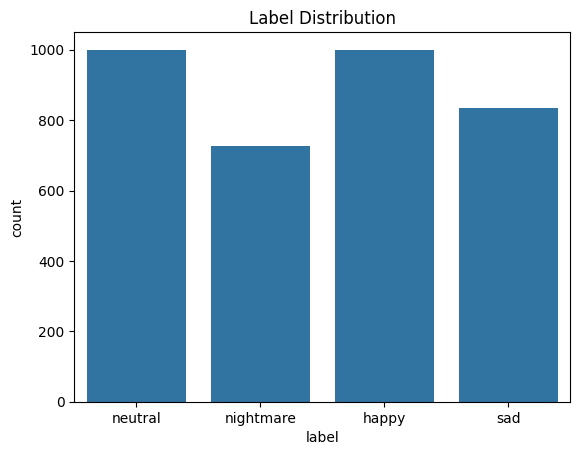

In [28]:
# Overview
import seaborn as sns
import matplotlib.pyplot as plt
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

# Label distribution
sns.countplot(x='label', data=df)
plt.title("Label Distribution")
plt.show()


In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Encode labels
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

# Mapping (save for inference)
label2idx = {label: idx for idx, label in enumerate(label_encoder.classes_)}
idx2label = {idx: label for label, idx in label2idx.items()}

df.head()


,content,label,label_encoded
0,(1960-05-04)I had another neat dream about Blake.,neutral,1
1,(1963-??-??)I had a Salvador Dali dream where ...,neutral,1
2,(1964-??-??)A red faced devil comes to me and ...,nightmare,2
3,(1969-??-??)I woke from a nap unable to rememb...,neutral,1
4,(1974-01-17)Dreamt of IVs. Lots of waterfalls.,neutral,1


In [30]:
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

# Tokenizer
def tokenizer(text):
    return text.lower().split()

# Build vocab manually
counter = Counter()
for line in df["content"]:
    counter.update(tokenizer(line))

# Limit vocab size (optional)
vocab_limit = 10000
special_tokens = ["<unk>", "<pad>"]
most_common = special_tokens + [word for word, _ in counter.most_common(vocab_limit - len(special_tokens))]
word2idx = {word: idx for idx, word in enumerate(most_common)}
word2idx["<unk>"] = 0
word2idx["<pad>"] = 1
pad_idx = word2idx["<pad>"]

def numericalize(text):
    return [word2idx.get(token, word2idx["<unk>"]) for token in tokenizer(text)]

# Example
print(numericalize("This is just a dream"))


[29, 9, 47, 5, 446]


In [31]:
df=df.drop('label', axis=1)

In [32]:
df

,content,label_encoded
0,(1960-05-04)I had another neat dream about Blake.,1
1,(1963-??-??)I had a Salvador Dali dream where ...,1
2,(1964-??-??)A red faced devil comes to me and ...,2
3,(1969-??-??)I woke from a nap unable to rememb...,1
4,(1974-01-17)Dreamt of IVs. Lots of waterfalls.,1
...,...,...
3556,"(12/7/92)I am some sort of clerk, perhaps a me...",2
3557,(12/2/92)I am watching TV early in the morning...,3
3558,"(8/3/94)I'm in the library, just arriving (lat...",3
3559,"[lost - do some stuff, notice the clock, somet...",3


In [33]:
# 🧪 5. Stratified Split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label_encoded"], random_state=42)


In [34]:
# 🧺 6. Dataset + Dataloader
class DreamDataset(Dataset):
    def __init__(self, df, max_len=100):
        self.texts = df["content"].tolist()
        self.labels = df["label_encoded"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = numericalize(self.texts[idx])[:self.max_len]
        length = len(tokens)
        padded = tokens + [pad_idx] * (self.max_len - length)
        return torch.tensor(padded), torch.tensor(self.labels[idx])

train_data = DreamDataset(train_df)
val_data = DreamDataset(val_df)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)


In [35]:
# 🧠 7. TextCNN Model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[3, 4, 5], num_filters=100):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embed_dim)) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [B, L, E]
        x = x.unsqueeze(1)     # [B, 1, L, E]
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max(pool, dim=2)[0] for pool in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        return self.fc(x)

model = TextCNN(vocab_size=len(word2idx), embed_dim=128, num_classes=len(label2idx)).to(device)


In [36]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, dataloader, criterion, device, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n🧪 Validation Loss: {total_loss / len(dataloader):.4f}")
    print(f"✅ Accuracy: {acc:.4f} | 🎯 F1 Score: {f1:.4f}\n")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Epoch 1 | 🧠 Loss: 125.1294 | ✅ Train Accuracy: 0.3876
Epoch 2 | 🧠 Loss: 92.8455 | ✅ Train Accuracy: 0.5565
Epoch 3 | 🧠 Loss: 77.2702 | ✅ Train Accuracy: 0.6531
Epoch 4 | 🧠 Loss: 64.5030 | ✅ Train Accuracy: 0.7173
Epoch 5 | 🧠 Loss: 53.1898 | ✅ Train Accuracy: 0.7746
Epoch 6 | 🧠 Loss: 45.8249 | ✅ Train Accuracy: 0.8114
Epoch 7 | 🧠 Loss: 38.2646 | ✅ Train Accuracy: 0.8381
Epoch 8 | 🧠 Loss: 31.7983 | ✅ Train Accuracy: 0.8687
Epoch 9 | 🧠 Loss: 27.2264 | ✅ Train Accuracy: 0.8869
Epoch 10 | 🧠 Loss: 21.6684 | ✅ Train Accuracy: 0.9161
Epoch 11 | 🧠 Loss: 18.1896 | ✅ Train Accuracy: 0.9266
Epoch 12 | 🧠 Loss: 16.4088 | ✅ Train Accuracy: 0.9393
Epoch 13 | 🧠 Loss: 12.1590 | ✅ Train Accuracy: 0.9582
Epoch 14 | 🧠 Loss: 10.9405 | ✅ Train Accuracy: 0.9582
Epoch 15 | 🧠 Loss: 8.8575 | ✅ Train Accuracy: 0.9747
Epoch 16 | 🧠 Loss: 8.1172 | ✅ Train Accuracy: 0.9723
Epoch 17 | 🧠 Loss: 6.6417 | ✅ Train Accuracy: 0.9793
Epoch 18 | 🧠 Loss: 5.4080 | ✅ Train Accuracy: 0.9849
Epoch 19 | 🧠 Loss: 4.3015 | ✅ Train Accu

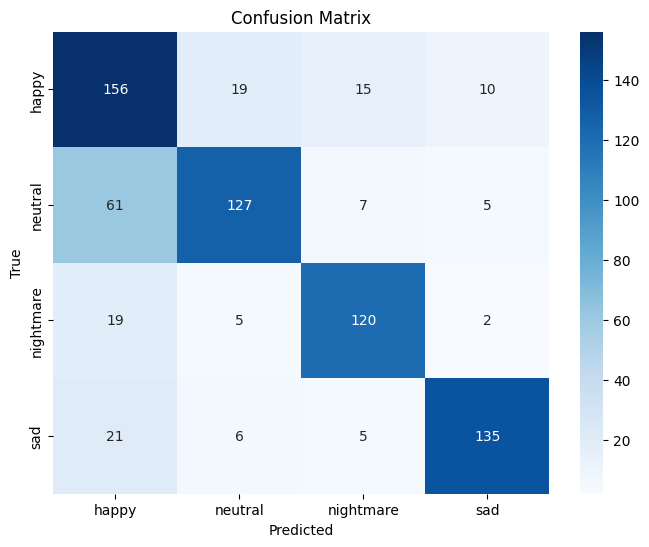

In [37]:
# 📉 Loss & Optimizer
class_counts = train_df["label_encoded"].value_counts().sort_index().values
weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 🏋️ Training Loop (no evaluation)
def train_model(model, epochs=25):
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

        acc = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1} | 🧠 Loss: {total_loss:.4f} | ✅ Train Accuracy: {acc:.4f}")

# 🚀 Start Training
train_model(model)

# 📊 Evaluate separately after training
evaluate(model, val_loader, loss_fn, device, label_encoder)


In [38]:
# 🔮 11. Inference Example
def predict(text):
    model.eval()
    tokens = numericalize(text)[:100]
    padded = tokens + [pad_idx] * (100 - len(tokens))
    input_tensor = torch.tensor(padded).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    return idx2label[pred]

print(predict("I had a strange dream about flying and falling"))


nightmare
